<a href="https://colab.research.google.com/github/federicocampo/CNN_prova/blob/Prime_modifiche/Copy_of_Lecture11_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the dataset from Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Reading the images

In [2]:
from matplotlib import pyplot as plt
from skimage.io import imread
import os
import glob
import numpy as np

Fare una read img migliore (?)

In [3]:
def read_imgs(dataset_path, classes):
  tmp = []
  labels = []
  for cls in classes:
    fnames = glob.glob(os.path.join(dataset_path, str(cls), '*.pgm'))
    tmp += [ imread(fname) for fname in fnames ]
    labels += len(fnames)*[cls]
  return np.array(tmp, dtype='float32')[..., np.newaxis]/255, np.array(labels)

In [4]:
PATH = 'gdrive/MyDrive/IMAGES/Mammography_micro'
#PATH = 'gdrive/MyDrive/Immagini'

In [5]:
train_dataset_path = os.path.join(PATH, 'Train')
x_train, y_train = read_imgs(train_dataset_path, [0, 1])

test_dataset_path =os.path.join(PATH, 'Test')
x_test, y_test = read_imgs(test_dataset_path, [0, 1])

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(396, 60, 60, 1) (396,)
(401, 60, 60, 1) (401,)


# Defining a CNN model

In [149]:
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Flatten, InputLayer, Activation, Dropout
from keras.models import Sequential

In [150]:
def make_model(shape=(60, 60, 1)):
  model = Sequential([
      
      Conv2D(8, (3,3), padding='same', input_shape=shape),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
      
      Conv2D(16, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D((2,2)),
        
      Conv2D(32, (3,3), padding='same'),
      BatchNormalization(),
      Activation('relu'),
      MaxPool2D(2, 2),


      Flatten(), 
      
      #Dense(32, activation = 'relu'),
      Dense(1, activation='sigmoid')
      
  ])
  
  return model

In [151]:
model = make_model()

In [152]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 60, 60, 8)         80        
_________________________________________________________________
batch_normalization_36 (Batc (None, 60, 60, 8)         32        
_________________________________________________________________
activation_36 (Activation)   (None, 60, 60, 8)         0         
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 30, 30, 16)        1168      
_________________________________________________________________
batch_normalization_37 (Batc (None, 30, 30, 16)        64        
_________________________________________________________________
activation_37 (Activation)   (None, 30, 30, 16)      

In [153]:
from keras.optimizers import SGD
model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='SGD', metrics = 'accuracy', loss='binary_crossentropy')

In [154]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "model-{epoch:02d}-{val_accuracy:.2f}.hdf5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [155]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [156]:
#history = model.fit(x_train, y_train, validation_split=0.2, epochs=20, batch_size=50, shuffle=True, callbacks=[checkpoint], verbose=0)
history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=10, shuffle=True, verbose=1)

Epoch 1/50
32/32 [==============================] - 1s 9ms/step - loss: 0.7218 - accuracy: 0.6487 - val_loss: 0.6602 - val_accuracy: 0.7125
Epoch 2/50
32/32 [==============================] - 0s 5ms/step - loss: 0.4368 - accuracy: 0.8027 - val_loss: 0.5816 - val_accuracy: 0.8125
Epoch 3/50
32/32 [==============================] - 0s 5ms/step - loss: 0.5872 - accuracy: 0.7687 - val_loss: 0.8180 - val_accuracy: 0.1875
Epoch 4/50
32/32 [==============================] - 0s 5ms/step - loss: 0.3759 - accuracy: 0.8383 - val_loss: 0.8868 - val_accuracy: 0.1750
Epoch 5/50
32/32 [==============================] - 0s 5ms/step - loss: 0.3817 - accuracy: 0.8328 - val_loss: 1.0645 - val_accuracy: 0.1750
Epoch 6/50
32/32 [==============================] - 0s 4ms/step - loss: 0.4374 - accuracy: 0.8196 - val_loss: 1.1815 - val_accuracy: 0.1500
Epoch 7/50
32/32 [==============================] - 0s 4ms/step - loss: 0.4114 - accuracy: 0.8309 - val_loss: 1.0653 - val_accuracy: 0.0250
Epoch 8/50
32/32 [==

In [157]:
model.save(os.path.join(PATH, 'model.hdf5'))

Grafico risutati

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


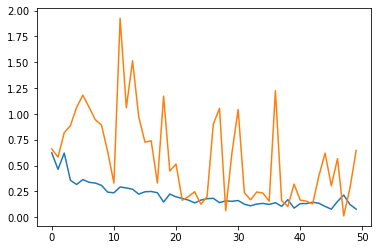

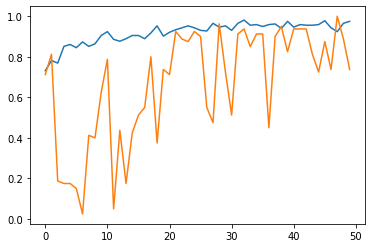

In [158]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

# Data augmentation
 Before we can run data aumentation with ImageDataGenerator we need to convert the PGM format to PNG

In [159]:
import PIL
import os

In [160]:
def convert_to_png(fname, dest_folder):
  if not os.path.exists(dest_folder):
    os.makedirs(dest_folder)
  dest_fname = os.path.basename(fname).replace('.pgm', '.png')
  dest_fname = os.path.join(dest_folder, dest_fname)
  PIL.Image.open(fname).convert('L').save(dest_fname)


Provare a fare una funzione migliore per convertire tutti i pgm in png

In [161]:
for data_path in [os.path.join(PATH, "Train"), os.path.join(PATH, "Test")]:
  for path, folders, fnames in os.walk(data_path):
    for fname in fnames:
      abs_path = os.path.join(path, fname)
      dest_folder = path.replace('Train', 'Train_png').replace('Test', 'Test_png')
      convert_to_png(abs_path, dest_folder)


# Data aumentation

In [162]:
import matplotlib.pyplot as plt

In [163]:
from keras.preprocessing.image import ImageDataGenerator

In [164]:
train_dataset_path = os.path.join(PATH, "Train_png")
img_width, img_height = (60, 60)

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='reflect',
        validation_split=0.3)
        
train_gen = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_width, img_height),
    color_mode='grayscale', 
    class_mode='binary',
    subset='training')

val_gen = train_datagen.flow_from_directory(
    train_dataset_path,
    target_size=(img_width, img_height),
    color_mode='grayscale',
    class_mode='binary',
    subset='validation')


Found 278 images belonging to 2 classes.
Found 118 images belonging to 2 classes.


In [165]:
train_gen.next()[0].shape

(32, 60, 60, 1)

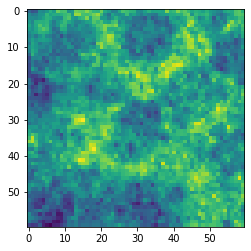

In [166]:
plt.imshow(train_gen.next()[0][4].squeeze())

In [167]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    "model_augmented.{epoch:02d}-{val_accuracy:.2f}.h5", 
    monitor='val_accuracy', 
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto', save_freq='epoch')

In [168]:
model = make_model()
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

In [169]:
batch_size=30
history = model.fit(
        train_gen,
        epochs=10,
        validation_data=val_gen
        )

Epoch 1/10
9/9 [==============================] - 2s 108ms/step - loss: 0.6264 - accuracy: 0.6299 - val_loss: 0.6909 - val_accuracy: 0.4746
Epoch 2/10
9/9 [==============================] - 1s 87ms/step - loss: 0.5556 - accuracy: 0.7153 - val_loss: 0.6743 - val_accuracy: 0.6610
Epoch 3/10
9/9 [==============================] - 1s 87ms/step - loss: 0.5335 - accuracy: 0.7468 - val_loss: 0.6784 - val_accuracy: 0.5169
Epoch 4/10
9/9 [==============================] - 1s 86ms/step - loss: 0.5767 - accuracy: 0.6303 - val_loss: 0.6825 - val_accuracy: 0.5763
Epoch 5/10
9/9 [==============================] - 1s 84ms/step - loss: 0.5287 - accuracy: 0.6964 - val_loss: 0.6753 - val_accuracy: 0.5593
Epoch 6/10
9/9 [==============================] - 1s 103ms/step - loss: 0.5178 - accuracy: 0.7601 - val_loss: 0.6892 - val_accuracy: 0.6610
Epoch 7/10
9/9 [==============================] - 1s 80ms/step - loss: 0.4716 - accuracy: 0.7544 - val_loss: 0.6902 - val_accuracy: 0.5847
Epoch 8/10
9/9 [=========

In [170]:
batch_size=32
history = model.fit(
        train_gen,
        steps_per_epoch=278 // batch_size,
        epochs=10,
        validation_data=val_gen,
        validation_steps= 118 // batch_size,
        callbacks=[checkpoint])

Epoch 1/10
8/8 [==============================] - 1s 98ms/step - loss: 0.4244 - accuracy: 0.8130 - val_loss: 0.7400 - val_accuracy: 0.5312

Epoch 00001: val_accuracy improved from -inf to 0.53125, saving model to model_augmented.01-0.53.h5
Epoch 2/10
8/8 [==============================] - 1s 91ms/step - loss: 0.4334 - accuracy: 0.8089 - val_loss: 0.7541 - val_accuracy: 0.5417

Epoch 00002: val_accuracy improved from 0.53125 to 0.54167, saving model to model_augmented.02-0.54.h5
Epoch 3/10
8/8 [==============================] - 1s 94ms/step - loss: 0.3852 - accuracy: 0.8171 - val_loss: 0.7536 - val_accuracy: 0.5312

Epoch 00003: val_accuracy did not improve from 0.54167
Epoch 4/10
8/8 [==============================] - 1s 88ms/step - loss: 0.3708 - accuracy: 0.8211 - val_loss: 0.8000 - val_accuracy: 0.5000

Epoch 00004: val_accuracy did not improve from 0.54167
Epoch 5/10
8/8 [==============================] - 1s 85ms/step - loss: 0.4013 - accuracy: 0.8374 - val_loss: 0.7990 - val_accur

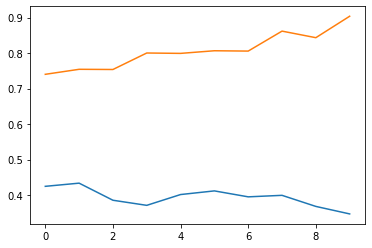

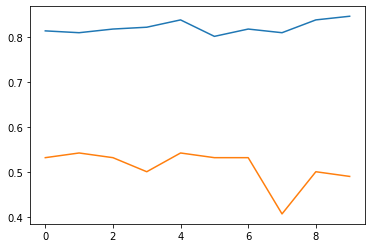

In [171]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

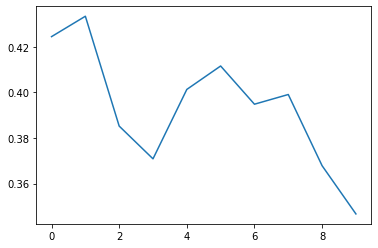

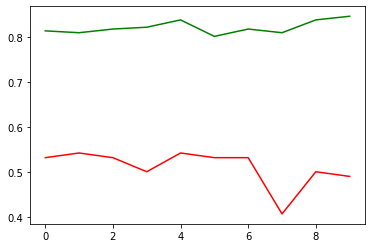

In [172]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.figure()
plt.plot(history.history['val_accuracy'], color='r')
plt.plot(history.history['accuracy'], color='g')


# Saving the model

In [173]:
model.save(os.path.join(PATH, 'model_augmented.hdf5'))

In [174]:
from keras.models import load_model
imported_model = load_model(os.path.join(PATH, 'model_augmented.hdf5'))
imported_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 60, 60, 8)         80        
_________________________________________________________________
batch_normalization_39 (Batc (None, 60, 60, 8)         32        
_________________________________________________________________
activation_39 (Activation)   (None, 60, 60, 8)         0         
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 30, 30, 16)        1168      
_________________________________________________________________
batch_normalization_40 (Batc (None, 30, 30, 16)        64        
_________________________________________________________________
activation_40 (Activation)   (None, 30, 30, 16)      

# Evaluate the performances of the two models

In [ ]:
noaug_model = load_model(os.path.join(PATH, 'model.hdf5'))
aug_model = load_model(os.path.join(PATH, 'model_augmented.hdf5'))

In [ ]:
#aug_model=model

In [ ]:
x_test, y_test = read_imgs(os.path.join(PATH, "Test"), [0,1])

In [ ]:
noaug_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 5ms/step - loss: 0.9235 - accuracy: 0.5112


[0.9234771132469177, 0.5112219452857971]

In [ ]:
aug_model.evaluate(x_test, y_test)

13/13 [==============================] - 0s 2ms/step - loss: 0.8361 - accuracy: 0.5112


[0.8360695242881775, 0.5112219452857971]

# Visualizing

In [ ]:
model= load_model(os.path.join(PATH, 'model_augmented.hdf5'))

In [ ]:
model.layers


In [ ]:
from keras import models
layer_outputs = [layer.output for layer in model.layers]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [ ]:
micro_calc = val_gen.next()[0][2][np.newaxis,...]


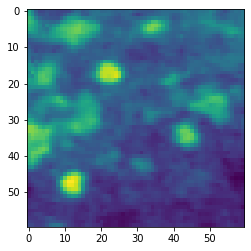

In [ ]:
plt.imshow(micro_calc.squeeze())

In [ ]:
activations = activation_model.predict(micro_calc)

In [ ]:
len(activations) == len(model.layers)

True

In [ ]:
activations[0].shape

(1, 60, 60, 8)

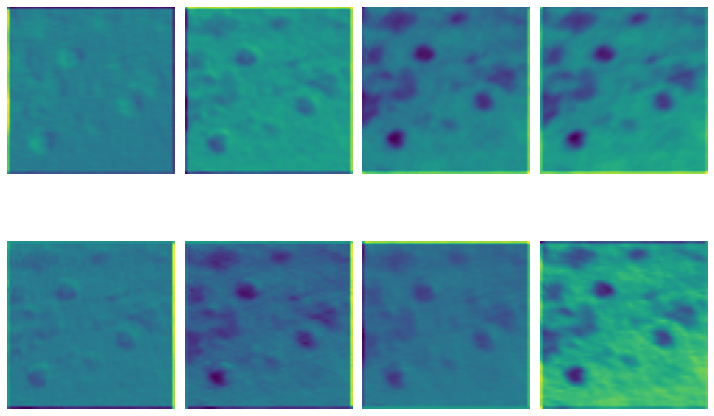

In [ ]:
fig = plt.figure(figsize=(10,10))
for k in range(8):
  plt.subplot(2,4, k+1)
  plt.imshow(activations[0][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.5, wspace=0.2)
fig.tight_layout(pad=1)

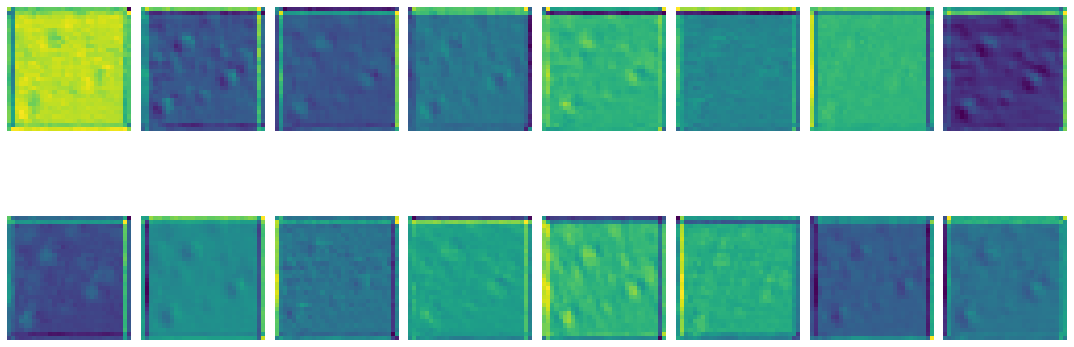

In [ ]:
fig = plt.figure(figsize=(15,15))

for k in range(16):
  plt.subplot(2,8, k+1)
  plt.imshow(activations[5][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.9, wspace=0.2)
fig.tight_layout(pad=1)

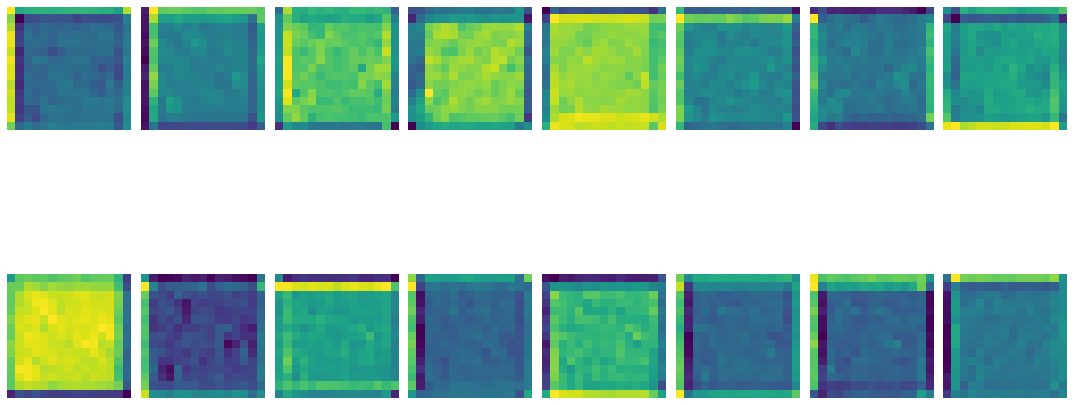

In [ ]:
fig = plt.figure(figsize=(15,15))
for k in range(16):
  plt.subplot(4,8, k+1)
  plt.imshow(activations[8][..., k].squeeze())
  plt.axis(False)
fig.subplots_adjust(hspace=-0.9, wspace=0.2)
fig.tight_layout(pad=1)

## Visualizing filters

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[0].get_weights()
filters = (filters - filters.min())/(filters.max() - filters.min())
filters = filters.squeeze()

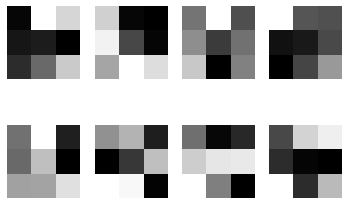

In [ ]:
for k in range(8):
  plt.subplot(2, 4, k+1)
  plt.imshow(filters[:,:,k], cmap='gray')
  plt.axis(False)

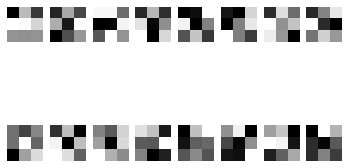

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[4].get_weights()
filters = (filters - filters.min())/(filters.max() - filters.min())
filters = filters.squeeze()
for k in range(16):
  plt.subplot(2, 8, k+1)
  plt.imshow(filters[:,:,1 ,k], cmap='gray')
  plt.axis(False)

In [ ]:
filters.shape

(3, 3, 8, 16)